In [101]:
# load libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os

# see process_data.py
import process_data as data

In [102]:
# load raw data 
mortality_path = os.path.join("..", "data", "mortality_profiles")
mortality_data = glob.glob(os.path.join(mortality_path, "*.csv")) 
mortality_data = mortality_data[1:len(mortality_data) - 1] # only get 1999 - 2021 data
print(mortality_data) 

['..\\data\\mortality_profiles\\1999-2008-final-deaths-by-year-by-zip-code.csv', '..\\data\\mortality_profiles\\2009-2018-final-deaths-by-year-by-zip-code.csv', '..\\data\\mortality_profiles\\2019-2021-final-deaths-by-year-by-zip-code.csv']


  ZIPCODE                                           geometry
0   90001  POLYGON ((-118.24338 33.98924, -118.24333 33.9...
1   90002  POLYGON ((-118.23431 33.96101, -118.23425 33.9...
2   90003  POLYGON ((-118.28285 33.97597, -118.28285 33.9...
3   90004  POLYGON ((-118.28410 34.08349, -118.28425 34.0...
4   90005  MULTIPOLYGON (((-118.33541 34.06179, -118.3350...


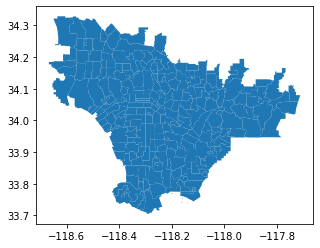

In [103]:
# load zipcode data 
zipcodes_shp = os.path.join("..", "processed", "collapsed_measures", "zipcodes_processed.shp") 
zipcodes = gpd.read_file(zipcodes_shp)
zipcodes["ZIPCODE"] = zipcodes["ZIPCODE"].astype("string").str[0:5]
print(zipcodes.head())

zipcodes.plot()
plt.show()

(257, 2)


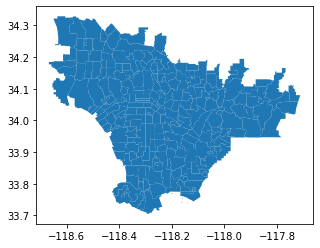

In [104]:
# see how many zipcodes are covered by mortality data 

# open up any csv 
ex_df = pd.read_csv(mortality_data[0])
ex_grouped = ex_df.groupby(by="ZIP_Code", as_index=False).sum() # do any operation
ex_zipcodes = ex_grouped["ZIP_Code"].astype("string")

# plot these zipcodes
zips_to_plot = zipcodes[zipcodes["ZIPCODE"].isin(ex_zipcodes.to_list())]
print(zips_to_plot.shape) # all zipcodes are covered! yayay
zips_to_plot.plot()
plt.show()


In [124]:
# check if zipcodes are same across files 
for data in mortality_data:
    df = pd.read_csv(data)
    df_grouped = df.groupby(by="ZIP_Code", as_index=False).sum() # do any operation
    df_zips = df_grouped["ZIP_Code"].astype("string")

    if (not df_zips.equals(ex_zipcodes)):
        raise Exception(f"{data} has dif zipcodes")

In [105]:
# wanted colnames 
age_colnames = {
    "Under 1 year" : "Age_Under_1",
    "1-4 years" : "Age_1_4", 
    "5-14 years" : "Age_5_14", 
    "15-24 years" : "Age_15_24", 
    "25-34 years" : "Age_25_34", 
    "35-44 years" : "Age_35_44", 
    "45-54 years" : "Age_45_54", 
    "55-64 years" : "Age_55_64", 
    "65-74 years" : "Age_65_74", 
    "75-84 years" : "Age_75_84", 
    "85 years and over" : "Age_85_and_Over" 
}

cause_colnames = {
    "Accidents (unintentional injuries)" : "Accidents", 
    "All causes (total)" : "Total",
    "Alzheimer's disease" : "Alzheimers",
    "Assault (homicide)" : "Homicide", 
    "Cerebrovascular diseases" : "Cerebrovascular",
    "Chronic liver disease and cirrhosis" : "Cirrhosis",
    "Chronic lower respiratory diseases" : "Respiratory",
    "Diabetes mellitus" : "Diabetes",
    "Diseases of heart" : "Heart",
    "Essential hypertension and hypertensive renal disease" : "Hypertension", 
    "Influenza and pneumonia" : "InfluenzaPneumonia",
    "Intentional self-harm (suicide)" : "Suicide",
    "Malignant neoplasms" : "Neoplasms", 
    "Nephritis, nephrotic syndrome and nephrosis" : "Nephrosis",
    "Parkinson's disease" : "Parkinsons"
}

new_colnames = age_colnames | cause_colnames | {"ZIP_Code" : "Zipcode"}
print(new_colnames)

{'Under 1 year': 'Age_Under_1', '1-4 years': 'Age_1_4', '5-14 years': 'Age_5_14', '15-24 years': 'Age_15_24', '25-34 years': 'Age_25_34', '35-44 years': 'Age_35_44', '45-54 years': 'Age_45_54', '55-64 years': 'Age_55_64', '65-74 years': 'Age_65_74', '75-84 years': 'Age_75_84', '85 years and over': 'Age_85_and_Over', 'Accidents (unintentional injuries)': 'Accidents', 'All causes (total)': 'Total', "Alzheimer's disease": 'Alzheimers', 'Assault (homicide)': 'Homicide', 'Cerebrovascular diseases': 'Cerebrovascular', 'Chronic liver disease and cirrhosis': 'Cirrhosis', 'Chronic lower respiratory diseases': 'Respiratory', 'Diabetes mellitus': 'Diabetes', 'Diseases of heart': 'Heart', 'Essential hypertension and hypertensive renal disease': 'Hypertension', 'Influenza and pneumonia': 'InfluenzaPneumonia', 'Intentional self-harm (suicide)': 'Suicide', 'Malignant neoplasms': 'Neoplasms', 'Nephritis, nephrotic syndrome and nephrosis': 'Nephrosis', "Parkinson's disease": 'Parkinsons', 'ZIP_Code': '

In [155]:
years = range(2005, 2020)
counts_df = pd.DataFrame()

for data in mortality_data:
    df = pd.read_csv(data)
    # df_years = df.loc[df["Year"].isin(years)]
    df_filterd = df.loc[(df["Year"].isin(years)) & (df["ZIP_Code"].isin(zipcodes["ZIPCODE"].to_list()))].reset_index()

    # extract age-specific, all-cause counts
    df_age = df_filterd[df_filterd["Strata"] == "Age"]
    df_age = df_age.pivot(index=["Year", "ZIP_Code"], columns="Strata_Name", values="Count")

    # extract cause-specific, all-age counts (and all-cause, all-age)
    df_cause = df_filterd[df_filterd["Strata"] == "Total Population"]
    df_cause = df_cause.pivot(index=["Year", "ZIP_Code"], columns="Cause_Desc", values="Count")

    # join dfs
    joined = df_age.join(df_cause, on=["Year", "ZIP_Code"]).reset_index()
    joined.rename(columns=new_colnames, inplace=True)

    # concat to final df
    counts_df = pd.concat([counts_df, joined], ignore_index=True)


In [160]:
df["ZIP_Code"].astype("string")
df["ZIP_Code"].isin(zipcodes["ZIPCODE"].to_list())

# TODO figure out why this is false....

0         False
1         False
2         False
3         False
4         False
          ...  
226435    False
226436    False
226437    False
226438    False
226439    False
Name: ZIP_Code, Length: 226440, dtype: bool

In [109]:
# save counts df
out_dir = os.path.join("..", "processed", "health_data")
counts_df.to_csv(os.path.join(out_dir, "mortality_counts.csv"), index=False)

In [111]:
# load population data 
pop_path = os.path.join("..", "data", "pca", "ACSDP5Y2022.DP05-Data.csv ")
pop_data = pd.read_csv(pop_path)
print(pop_data.columns)

Index(['GEO_ID', 'NAME', 'DP05_0001E', 'DP05_0001M', 'DP05_0002E',
       'DP05_0002M', 'DP05_0003E', 'DP05_0003M', 'DP05_0004E', 'DP05_0004M',
       ...
       'DP05_0087PM', 'DP05_0088PE', 'DP05_0088PM', 'DP05_0089PE',
       'DP05_0089PM', 'DP05_0090PE', 'DP05_0090PM', 'DP05_0091PE',
       'DP05_0091PM', 'Unnamed: 366'],
      dtype='object', length=367)


(250, 2)


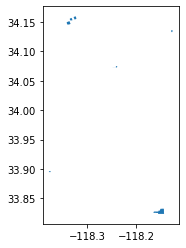

In [122]:
# get cols of interest
cols_to_keep = ["NAME",	"DP05_0001E"] # zipcode name, zipcode pop 
pop_df = pop_data[cols_to_keep]

# remove second row (descriptions of col names) 
pop_df = pop_df.drop([0])
pop_df.reset_index(drop=True, inplace=True)

# format zipcodes (remove ZCTA5_)
pop_df["NAME"] = pop_df["NAME"].str[6:]

# rename columns 
pop_df = pop_df.rename(columns={"NAME": "Zipcode", "DP05_0001E": "TotPop"}) 

# get pop for relevant zipcodes (assumed same across mortality data)
pop_subset_df = pop_df[pop_df["Zipcode"].isin(zipcodes["ZIPCODE"].to_list())] # hceeck here...
print(pop_subset_df.shape) 

# missing data for 7 zipcodes
pop_missing = zipcodes[~zipcodes["ZIPCODE"].isin(pop_subset_df["Zipcode"].to_list())]
print(pop_missing.shape)
pop_missing.plot()
plt.show()


In [123]:
pop_subset_df.head()

,Zipcode,TotPop
0,90001,57652
1,90002,53108
2,90003,75024
3,90004,58833
4,90005,37754


In [147]:
# standardize counts to get rate per 100,000 ppl 
rate_df = counts_df.copy()
count_cols = rate_df.columns[2:]
zip_pops = pd.DataFrame(pop_subset_df["TotPop"].astype("float"))

years = range(2005,2021)
for year in years: 
    # yearly_data = rate_df.loc[rate_df["Year"] == year]
    # yearly_zips = yearly_data["Zipcode"]

    # # get population data for matching zips 
    # zips_df = pop_df.loc[pop_df["Zipcode"].isin(yearly_zips.to_list())].set_index(yearly_data.index)
    # zip_pops = zips_df["TotPop"].astype("float")

    # # divide everything in counts_df by filtered pop data 
    # rate = rate_df.loc[rate_df["Year"] == year, count_cols].div(zip_pops, axis=0).mul(1e5)
    # rate_df.loc[rate_df["Year"] == year, count_cols] = rate


    # divide everything in counts_df by filtered pop data 
    counts = rate_df.loc[rate_df["Year"] == year, count_cols]
    print(counts.index)
    print(zip_pops.index)
    # print(counts.index)
    # zip_pops = zip_pops.set_index(counts.index)
    # rate = counts.div(zip_pops, axis=0).mul(1e5)
    # rate_df.loc[rate_df["Year"] == year, count_cols] = rate



Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663],
      dtype='int64', length=2664)
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288],
      dtype='int64', length=250)
Index([2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673,
       ...
       5318, 5319, 5320, 5321, 5322, 5323, 5324, 5325, 5326, 5327],
      dtype='int64', length=2664)
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288],
      dtype='int64', length=250)
Index([5328, 5329, 5330, 5331, 5332, 5333, 5334, 5335, 5336, 5337,
       ...
       7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991],
      dtype='int64', length=2664)
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288],
      dtype='int

In [148]:
rate_df[rate_df["Year"] == 2005]

,Year,Zipcode,Age_1_4,Age_15_24,Age_25_34,Age_35_44,Age_45_54,Age_5_14,Age_55_64,Age_65_74,...,Cirrhosis,Respiratory,Diabetes,Heart,Hypertension,InfluenzaPneumonia,Suicide,Neoplasms,Nephrosis,Parkinsons
0,2005,90001,NaN,16.0,13.0,13.0,28.0,NaN,27.0,32.0,...,13.0,NaN,NaN,74.0,NaN,NaN,NaN,40.0,NaN,0.0
1,2005,90002,NaN,19.0,21.0,18.0,24.0,0.0,43.0,55.0,...,NaN,NaN,NaN,74.0,NaN,NaN,NaN,50.0,NaN,NaN
2,2005,90003,NaN,19.0,NaN,20.0,39.0,NaN,51.0,41.0,...,NaN,12.0,17.0,90.0,NaN,NaN,NaN,59.0,NaN,NaN
3,2005,90004,NaN,NaN,NaN,15.0,34.0,NaN,22.0,45.0,...,NaN,NaN,NaN,79.0,NaN,NaN,NaN,70.0,NaN,0.0
4,2005,90005,NaN,NaN,NaN,NaN,15.0,0.0,23.0,27.0,...,NaN,NaN,NaN,50.0,NaN,NaN,NaN,39.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2659,2005,96157,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2660,2005,96158,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
2661,2005,96160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2662,2005,96161,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,15.0,0.0,0.0


In [146]:
zip_pops = pd.DataFrame(pop_subset_df["TotPop"].astype("float"))
print(zip_pops.index)

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288],
      dtype='int64', length=250)


In [142]:
rate

,Age_1_4,Age_15_24,Age_25_34,Age_35_44,Age_45_54,Age_5_14,Age_55_64,Age_65_74,Age_75_84,Age_85_and_Over,...,Cirrhosis,Respiratory,Diabetes,Heart,Hypertension,InfluenzaPneumonia,Suicide,Neoplasms,Nephrosis,Parkinsons


In [133]:
pop_subset_df.tail()

,Zipcode,TotPop
284,91790,44855
285,91791,33902
286,91792,31208
287,91801,53320
288,91803,29006


In [134]:
counts_df.tail()

,Year,Zipcode,Age_1_4,Age_15_24,Age_25_34,Age_35_44,Age_45_54,Age_5_14,Age_55_64,Age_65_74,...,Cirrhosis,Respiratory,Diabetes,Heart,Hypertension,InfluenzaPneumonia,Suicide,Neoplasms,Nephrosis,Parkinsons
39955,2019,96157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39956,2019,96158,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
39957,2019,96160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39958,2019,96161,0.0,0.0,NaN,0.0,NaN,0.0,11.0,15.0,...,NaN,NaN,NaN,16.0,0.0,NaN,NaN,24.0,NaN,NaN
39959,2019,96162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
